## Tropospheric delay correction using GACOS products ##

This notebook describe the procedure to correct tropospheric delays for InSAR time-series using the products from GACOS (http://ceg-research.ncl.ac.uk/v2/gacos/). One would need to submit jobs on GACOS website and download the products, then run the following procedures, it includes:

1. cropped it for my area of interest
2. resize it to the same resolution/pixel_size as interferograms
3. Project the zenith to the LOS direction
4. Reference it to the same reference pixel as interferograms.

In [1]:
## Tropospheric delay correction using GACOS from New Castle U
## for geocoded dataset
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
from mintpy.objects import timeseries
from mintpy.utils import ptime, readfile, utils as ut
from mintpy import view

ztd_dir = os.path.expanduser('~/insarlab/Kirishima/AlosAT424F620_630/GACOS')
proj_dir = os.path.expanduser('~/insarlab/Kirishima/KirishimaAlosAT424/mintpy')

out_file = os.path.join(proj_dir, 'inputs/GACOS.h5')
ts_file = os.path.join(proj_dir, 'timeseries.h5')
geom_file = os.path.join(proj_dir, 'inputs/geometryGeo.h5')

In [2]:
def get_geo_delay(fztd, geo_box, atr, inc_angle):
    meta = readfile.read_attribute(fztd)
    coord = ut.coordinate(meta)
    box = coord.box_geo2pixel(geo_box)
    phs = readfile.read(fztd, box=box)[0]
    phs[phs == 0] = np.nan

    # interpolation
    out_shape = (int(atr['LENGTH']), int(atr['WIDTH']))
    phs = resize(phs, out_shape, order=1, mode='constant', anti_aliasing=True, preserve_range=True)

    phs /= np.cos(inc_angle * np.pi / 180)
    phs -= phs[int(atr['REF_Y']), int(atr['REF_X'])]
    phs *= -1
    return phs

In [3]:
# 1. get time-series file info
obj = timeseries(ts_file)
obj.open()
atr = readfile.read_attribute(ts_file)

# get box_box
pixel_box = (0, 0, int(atr['WIDTH']), int(atr['LENGTH']))
geo_box = ut.coordinate(atr).box_pixel2geo(pixel_box)

# get inc_angle
inc_angle = readfile.read(geom_file, datasetName='incidenceAngle')[0]

# get grib file list
fztd_list = [os.path.join(ztd_dir, '{}.ztd'.format(i)) for i in obj.dateList]

open timeseries file: timeseries.h5


In [4]:
# calculate deley time-series
num_date = obj.numDate
tropo = np.zeros((num_date, obj.length, obj.width), dtype=np.float32)
prog_bar = ptime.progressBar(maxValue=num_date)
for i in range(num_date):
    fztd = fztd_list[i]
    tropo[i, :, :] = get_geo_delay(fztd, geo_box, atr, inc_angle)
    prog_bar.update(i+1, suffix=os.path.basename(fztd))
prog_bar.close()
tropo -= np.tile(tropo[0, :, :], (num_date, 1, 1))

# write deley to h5 file
obj_out = timeseries(out_file)
obj_out.write2hdf5(data=tropo,
                   dates=obj.dateList,
                   metadata=atr,
                   refFile=ts_file)

[==================================================] 20110407.ztd    1s /     0s 
create timeseries HDF5 file: /Users/yunjunz/insarlab/Kirishima/KirishimaAlosAT424/mintpy/inputs/GACOS.h5 with w mode
create dataset /timeseries of float32    in size of (27, 433, 649) with compression=None
create dataset /dates      of |S8        in size of (27,)
create dataset /bperp      of float32    in size of (27,)
finished writing to /Users/yunjunz/insarlab/Kirishima/KirishimaAlosAT424/mintpy/inputs/GACOS.h5


'/Users/yunjunz/insarlab/Kirishima/KirishimaAlosAT424/mintpy/inputs/GACOS.h5'

In [5]:
# correct time-series
work_dir = os.path.expanduser('~/insarlab/Kirishima/KirishimaAlosAT424/mintpy')
os.chdir(work_dir)
print('Go to directory', work_dir)

!diff.py timeseries.h5 inputs/GACOS.h5 -o timeseries_GACOS.h5
!remove_ramp.py timeseries_GACOS.h5 -m maskTempCoh.h5 -s quadratic
!dem_error.py timeseries_GACOS_ramp.h5 -t pysarApp_template.txt

Go to directory /Users/yunjunz/insarlab/Kirishima/KirishimaAlosAT424/mintpy
timeseries.h5 - ['inputs/GACOS.h5'] --> timeseries_GACOS.h5
input files are: timeseries and timeseries
open timeseries file: timeseries.h5
open timeseries file: GACOS.h5
reading timeseries data from file: timeseries.h5 ...
create timeseries HDF5 file: timeseries_GACOS.h5 with w mode
create dataset /timeseries of float32    in size of (27, 433, 649) with compression=None
create dataset /dates      of |S8        in size of (27,)
create dataset /bperp      of float32    in size of (27,)
finished writing to timeseries_GACOS.h5
remove quadratic ramp from file: timeseries_GACOS.h5
read mask file: maskTempCoh.h5
reading data ...
estimating phase ramp ...
create timeseries HDF5 file: timeseries_GACOS_ramp.h5 with w mode
create dataset /timeseries of float32    in size of (27, 433, 649) with compression=None
create dataset /dates      of |S8        in size of (27,)
create dataset /bperp      of float32    in size of (27

Go to directory /Users/yunjunz/insarlab/Kirishima/KirishimaAlosAT424/mintpy
view.py timeseries_GACOS_ramp_demErr.h5 -v -5 5 --noverbose


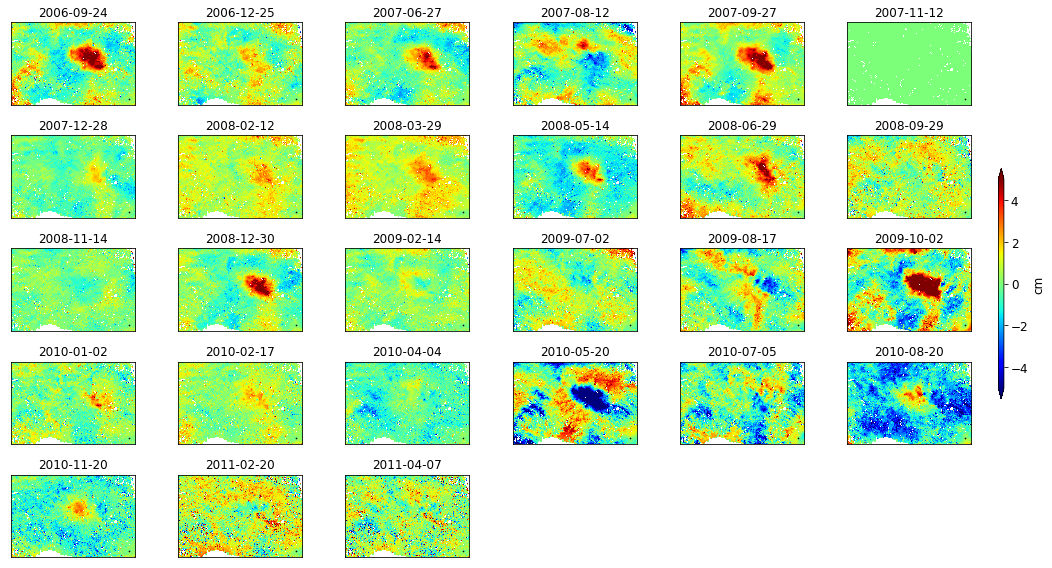

view.py timeseries_ERA5_ramp_demErr.h5 -v -5 5 --noverbose


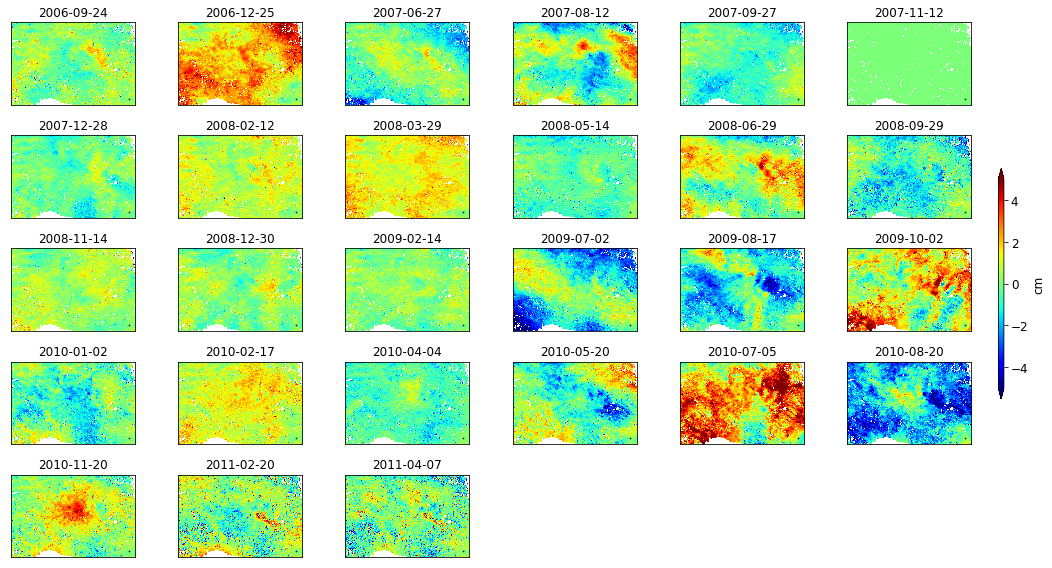

In [6]:
work_dir = os.path.expanduser('~/insarlab/Kirishima/KirishimaAlosAT424/mintpy')
os.chdir(work_dir)
print('Go to directory', work_dir)

for fname in ['timeseries_GACOS_ramp_demErr.h5', 'timeseries_ERA5_ramp_demErr.h5']:
    scp_args = '{} -v -5 5 --noverbose'.format(fname)
    print('view.py', scp_args)
    view.main(scp_args.split())